In [75]:
#https://analyticsindiamag.com/classifying-fake-and-real-job-advertisements-using-machine-learning/
!pip install WordCloud
!pip install spacy

     |████████████████████████████████| 71kB 2.0MB/s 
ERROR: atspy 0.2.8 has requirement tqdm==4.28.1, but you'll have tqdm 4.48.2 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, classification_report

from wordcloud import WordCloud
import spacy
from  spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC




In [2]:
data = pd.read_csv('fake_job_postings.csv')
data.shape

(17880, 18)

In [3]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
data.interpolate(inplace=True)
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
#Delete the unnecessary columns
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del data[col]

#Fill NaN values with blank space
data.fillna(' ', inplace=True)

data.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


,fraudulent,title
0,0,17014
1,1,866


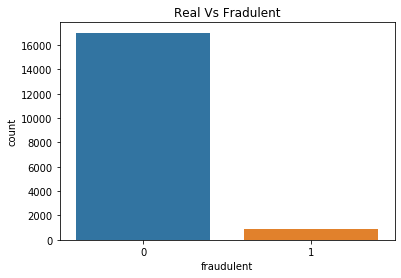

In [8]:
##Fraud and Real visualization
sns.countplot(data.fraudulent).set_title('Real Vs Fradulent')
data.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title', ascending=False)

Text(0.5, 0, 'Countries')

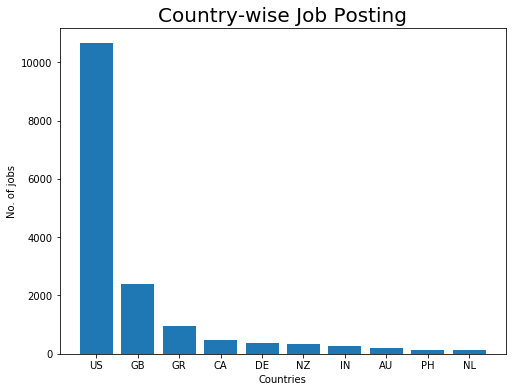

In [11]:
#In the next step, we will visualize the number of job postings by countries and by experience.
#Visualize by country
def split(location):
  l=location.split(',')
  return l[0]

data['country'] = data.location.apply(split)

country = dict(data.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)




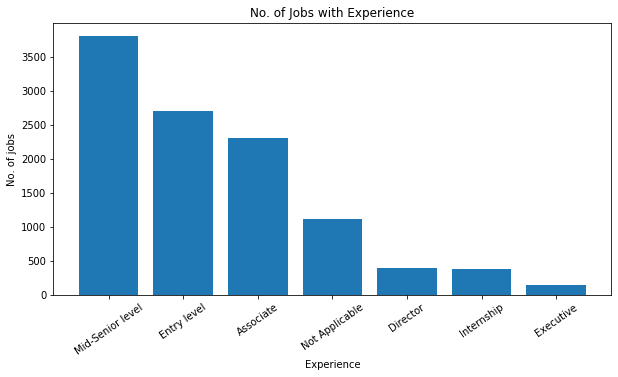

In [12]:
#Visualize the required experiences in the jobs
experience = dict(data.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values())
plt.title('No. of Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()


In [13]:
#Most Frequent jobs top 10
print(data.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [14]:
#Titles and count of fraudulent jobs
print(data[data.fraudulent==1].title.value_counts()[:10])

Cruise Staff Wanted *URGENT*                                            21
Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Payroll Clerk                                                           10
Network Marketing                                                       10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Account Sales Managers $80-$130,000/yr                                  10
Name: title, dtype: int64


In [15]:
#Titles and count of real jobs
print(data[data.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [16]:
#combine text in a sinlge column to start cleaning our data
data['text']=data['title']+' '+data['location']+' '+data['company_profile']+' '+data['description']+' '+data['requirements']+' '+data['benefits']
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['country']


In [17]:
data.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


In [18]:
#Separate fraud and actual jobs
fraudjobs_text = data[data.fraudulent==1].text
actualjobs_text = data[data.fraudulent==0].text

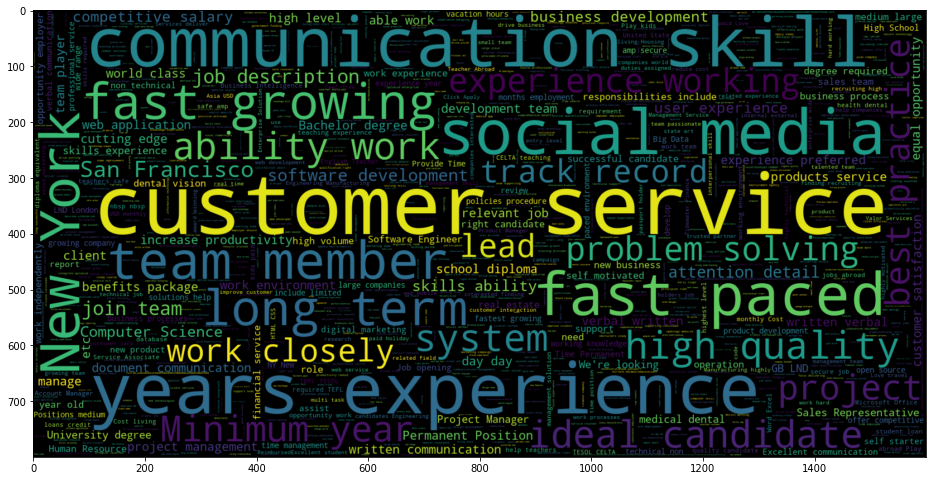

In [19]:
#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))

wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

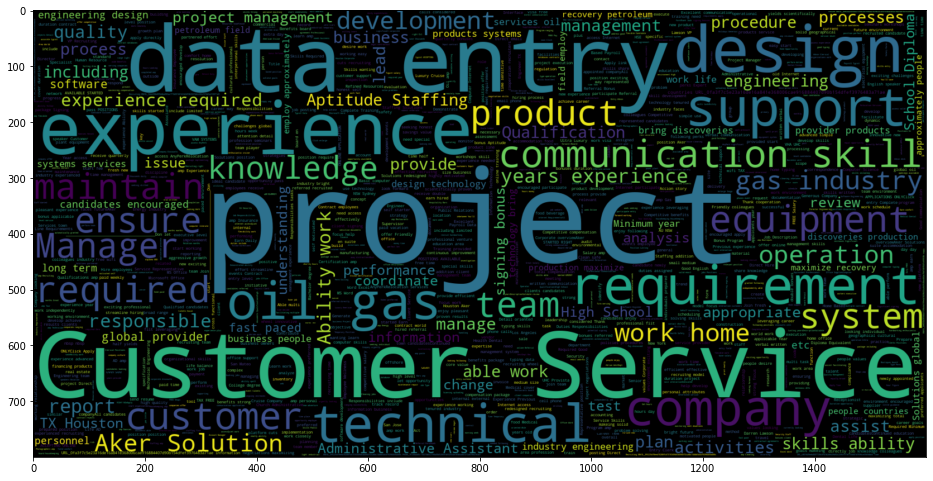

In [20]:
#Fraudulent jobs word cloud
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [21]:
#Cleaning and preprocessing
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
  # Creating our token object, which is used to create documents with linguistic annotations.
  mytokens = parser(sentence)

  # Lemmatizing each token and converting each token into lowercase
  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

  # Removing stop words
  mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

  # return a preprocessed list of tokens
  return mytokens


# Custom transformer using spaCy
class predictors(TransformerMixin):
  def transform(self, X, **transform_params):
    # Cleaning Text
    return [clean_text(text) for text in X]

  def fit(self, X, y=None, **fit_params):
    return self

  def get_params(self, deep=True):
    return {}


# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()



In [22]:
# Splitting dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, test_size=0.3)

#Train-test shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12516,)
(12516,)
(5364,)
(5364,)


In [23]:
#Support Vector Machine Classifier
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3))),
                 ('classifier', SVC())])


#Training the model.
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x7fb12396fe80>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 t...ttern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7fb1243121e0>,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3

In [25]:
# Predicting with a test dataset
y_pred = pipe.predict(X_test)

# Model Accuracy
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

Classification Accuracy: 0.976696495152871
Classification Report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5086
           1       0.99      0.55      0.71       278

    accuracy                           0.98      5364
   macro avg       0.98      0.78      0.85      5364
weighted avg       0.98      0.98      0.97      5364

Confusion Matrix

[[5085    1]
 [ 124  154]]


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, X_test, y_test, values_format=' ', ax=ax) 
plt.title('Confusion Matrix')
plt.show()